# Exercise 5 - Variance redudiction Methods

The tasks centers around simlation of the integral $\int_{0}^{1} e^x \, \mathrm{d}x$

In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as stats
import math as math

# UNCHANGED
## 1) Simulation of the integral using a Crude Monte Carlo Method

Using from the slides that the integral can be simplified to the expectation of $e^U$ where $U\sim Uniform(0,1)$. Simulate $n = 100$ instances of $e^x$, and find the mean. To get a 95% CI, use quantiles from t distribution with $n-1$ dof and $\alpha = 0.05$.

$$CI = \left[\bar{\theta} + \frac{S_\theta}{\sqrt{n}}t_{\frac{\alpha}{2}} (n-1);\bar{\theta} + \frac{S_\theta}{\sqrt{n}}t_{1-\frac{\alpha}{2}} (n-1) \right]$$

In [4]:
def crudeMC(n):
    U = rnd.uniform(size = n)
    x = np.exp(U)
    return x

def meanVar(x):
    mean = np.mean(x)
    var = np.var(x)
    return mean, var

def tConf(x, alpha, string):
    mean, var = meanVar(x)
    dof = len(x) - 1
    s = np.sqrt(var / len(x))
    a = stats.t.ppf(alpha/2, dof)
    b = stats.t.ppf(1 - alpha/2, dof)
    print("For", string, ":")
    print(f"Mean is {round(mean,3)}, with 95% confidence interval [{round(mean + s * a,2)},{round(mean + s * b,3)}]")

alpha = 0.05
n = 100
Xs_crude = crudeMC(n)
tConf(Xs_crude, alpha, "Crude Monte Carlo" )
print(f"The true value of the integral is: {round(np.exp(1) - np.exp(0),4)}")

For Crude Monte Carlo :
Mean is 1.763, with 95% confidence interval [1.67,1.857]
The true value of the integral is: 1.7183


# UNCHANGED
### 2) Antithetic variables
We can use Anithetic variables to exploit the fact that the integral $\int_{-\infty}^{\infty} e^x \, \mathrm{d}x$ is monotonely increasing. In practice this means we can use a single uniformly distributed value $U\sim Uniform(0,1)$, as in the Crude Monte Carlo Method, an use it to create a second uniformly distributed value $U-1$, almost for free. 

Using these we can create 2 estimates of the integral by $e^U$ and $e^{U-1}$, and take the average of these two to get a much more robust estimate of the integral

$$Y_i = \frac{e^{U_i - e^{U_i-1}}}{2}.$$

The expectation of the integral is now

$$E\left(Y_i\right).$$

$Y_i$ which on the slides is proved to have variance $\frac{1}{4} Var\left(e^{U_i}\right) + \frac{1}{4} Var\left(e^{1- U_i}\right) + \frac{1}{2} Cov\left(e^{U_i}, e^{1- U_i}\right)$. As $e^{U_i}$ and  $e^{1- U_i}$ are obviosly negatively correlated, this variance is much lower than before.

By rewriting $Y_i$ computing cost can be lowered, to only calculate a single exponential, resulting in an only marginally more expensive computation for $n$ $Y$'s compared to $n$ $X$'s.

$$Y_i = \frac{e^{U_i + \frac{e}{e^{U_i}}}}{2}.$$

Note: Had the integral not been monotonely increasing, say we had attemted to estimate some other function $f$, we could have had a situation where $f\left(U_i\right)$ and $f\left(U_i - 1\right)$ had been positively correlated, which could lead to a higher variance on $Y_i$. For the exponential function one of $e^{U_i}$ and $e^{U_i-1}$ is always large, and one is always small.

In [30]:
def antithetic(n):
    U = rnd.uniform(size = n)
    t = np.exp(U)
    Ys = 0.5 * (t + np.exp(1) / t )
    return Ys
Xs_antithetic = antithetic(100)
tConf(Xs_antithetic, alpha, "Antithetics Variables")

For Antithetics Variables :
Mean is 1.717, with 95% confidence interval [1.7,1.729]


# UNCHANGED
### 3) Control Variates
We can use the variable 

$$Z = X + c \left(Y - \mu_i\right),$$

instead of $X_i$ as the estimate of the integral. It can then be shown that $E\left(X\right) = E\left(Z\right)$, since

$$E\left(Z\right) = E\left(X\right) +E\left(c \left(Y - \mu_i\right)\right) $$
$$ = E\left(X\right) + c \left(E\left(Y \right) - E \left(\mu_i\right)\right) = E\left(X\right) + c \left(\mu_i - \mu_i\right) =E\left(X_i\right). $$

From the slides we also know that choosing the optimal $c = -\frac{Cov(X,Y)}{Var(Y)}$, results in a variance of $ Z $

$$ Var(Z) = Var(X) - \frac{Cov(X,Y)^2}{Var(Y)}. $$

For this specific problem we are given $X_i = e^{U_i}$, and it is natural to choose $Y_i = U_i$. This again exploits the covariance between $U_i$ and $X_i$, though this time negative correlation is not a requirement, as the covariance is squared. It should just be non-zero. 
As $E\left(U_i\right) = \frac{1}{2}$  we get

$$Z_i = e^{U_i} + c \left(U_i - \frac{1}{2}\right),$$

with $c\approx 0.14086.$

In [6]:
def controlVariates(n, alpha):
    U = rnd.uniform(size = n)
    Xs = np.exp(U)
    dof = len(Xs) - 1
    meanZ = np.mean(Xs)
    cov = np.mean(U * Xs) - np.mean(U) * np.mean(Xs) 
    varZ = np.var(Xs) - cov**2 / np.var(U)
    s = np.sqrt(varZ / len(Xs))
    a = stats.t.ppf(alpha/2, dof)
    b = stats.t.ppf(1 - alpha/2, dof)
    print("For Control Variates")
    print(f"Mean is {round(meanZ,2)}, with 95% confidence interval [{round(meanZ + s * a,2)},{round(meanZ + s * b,2)}]")
controlVariates(n, alpha)

For Control Variates
Mean is 1.71, with 95% confidence interval [1.7,1.72]


# UNCHANGED
### 4) Statified Sampling
Stratified sampling attemts to lower variance by (almost) gaurantying samples from the entire sample space, by cutting the sample space into $m$ pieces, and then sampling a number of variables from each. Here we´ll use $m = 10$ even intervals, to ensure even computational cost to the other methods, 10 $U_i$'s are generated in each interval.

The method then takes one $U_i$ from each interval and creates a single variable $W_i$ 

$$W_i = \frac{\sum_{k=1}^{m} X_{i,k}}{m}, $$

where $ k $ now denotes which interval the $X_i$ comes from. Still $X_i = e^{U_i}$, or $X_{i,k} = e^{U_{i,k}}$.

In [32]:
def stratSamples(n):
    num_ints = 10
    k = 1 / num_ints
    Xs = np.zeros(n)
    Us = np.zeros(num_ints)
    for j in range(n):
        for i in range(num_ints):
            a = k * i
            b = a + k 
            U = rnd.uniform(a, b, size = 1)
            Us[i] = U
        Xs[j] = np.mean(np.exp(Us))
    return Xs
n = 10
Xs_stratified = stratSamples(n)
tConf(Xs_stratified, alpha, "Stratified Sampling")

For Stratified Sampling :
Mean is 1.72, with 95% confidence interval [1.71,1.733]


### 1-4) Observations
The Crude MC method gives a very wide CI
All the variance reduction methods have succesfully narrowed the CI. We had the largest success with Control Variates.

# CHANGED
### 5) Use control variates to reduce the variance of the estimator in exercise 4
We'll use the arrival intervals as control variate, i.e. control variate $C_i \sim Exp(\lambda)$, note the difference between arrival intervals, which are just sampled, and arrival times which are the actual times customers arrive at, which is the cummulative arrival intervals.

Using the formula

$$Z_i = X_i + c \left(C_i - 1 \right), $$

$X_i$ is a list of bools of wether the customer with arrival interval $C_i$. Correlation is expected between $X_i$ and $C_i$ as a customer arriving quickly after another (small $C_i$) would presumably be blocked more often, as other customers have not had time to be served yet. We ofcourse know the mean of $C_i$, and can find the optimal $c = \frac{Cov\left(X, C \right)}{Var(C)}$ in each iteration. 

We're concerned with the mean of $X_i$, which is the blocking probability, and $Z_i$ is constructed to have the same mean.

In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as stats
import math as math
from scipy.stats import expon
import numpy as np
from discrete_event import Customer, main_loop, confidence_intervals, erlang_b, main_loop_array

#arrival time differences are exponentially distributed
lam = 1
total_customers = 10000
m = 10
s = 8
repititions = 10
#arrival time differences are exponentially distributed
arrival_interval = lambda : np.random.exponential(1/lam, size = total_customers)
service_time =lambda : expon.rvs(scale = s, size = total_customers)

In [2]:
blocked = main_loop(arrival_interval, service_time, m, repititions = repititions)/total_customers
#print("Blocking probability", blocked/total_customers * 100)
#confidence interval for the mean
theta = np.mean(blocked)
confint = confidence_intervals(blocked)
print(f"Estimated blocking probability {round(theta,3)*100}%\nTrue blocking probability {round(erlang_b(m, lam*s),3) *100}% (From Erlang formula)" )
print(f"95% CI for mean of blocking probability [{round(confint[0],4)}, {round(confint[1],4)}]")
print("Interval width", round(confint[1]-confint[0],4))

Estimated blocking probability 12.3%
True blocking probability 12.2% (From Erlang formula)
95% CI for mean of blocking probability [0.1194, 0.1259]
Interval width 0.0065


In [6]:
np.random.seed(2)
n = 10
Zs = []

for i in range(n):
    arrival_intervals = np.random.exponential(1/lam, size = total_customers)
    service_times = expon.rvs(scale = s, size = total_customers)
    blocked = main_loop_array(arrival_intervals, service_times, m)#/total_customers
    # Construct new variable
    c = -np.cov(arrival_intervals, blocked)[0,1] / np.var(arrival_intervals)
    Z = blocked + c * (arrival_intervals - 1)
    Zs.append(np.mean(Z))

tehta_Z = np.mean(Zs)
confint_Z = confidence_intervals(Zs)
print(f"Estimated blocking probability {round(theta,3)*100}%\nTrue blocking probability {round(erlang_b(m, lam*s),3) *100}% (From Erlang formula)" )
print(f"95% CI for mean of blocking probability [{round(confint_Z[0],4)}, {round(confint_Z[1],4)}]")
print("Interval width", round(confint_Z[1]-confint_Z[0],4))

Estimated blocking probability 11.899999999999999%
True blocking probability 12.2% (From Erlang formula)
95% CI for mean of blocking probability [0.1208, 0.1251]
Interval width 0.0043


### 6) Reduce variance for the difference between solutions with poisson arrivals and hyperexponential renewal process in exercise 4

Do this using Common Random Numbers (CRN). Using CRN we should be able to reduce the width of the CI og the difference in number of blocked customers between the two arrival processes. 

Using non-CRN's it should require 5 differerent processes of generating arrivals and leaves to compare the two processes. 2 generates the serice times for the processes, one generates arrivals for the poisson process and 2 generates renewals for the hyperexponential arrivals.

When using CRN's this can be reduced to 3. The services times can be generated from the same $U$, since they should be the same here. We can use a single $U$ as the exponential for the poisson and hyperexponential processes. We also need one more $U$ to flip between the two exponentials in the hyperexponential distribution.

Both test runs predict more blocked customers when assuming a hyperexponential renewal process. The width of the CI when using CRN's can be reduced to $\sim 1/3$ compared to just simulating the two processes independently.

In [68]:
import bisect as bisect
class Customer:
    def __init__(self, arrival_time, service_time):
        self.service_time = service_time
        self.blocked = False
        
        self.event = "arrival"
        self.event_time = arrival_time
      
                
    def arrive(self, servers, event_list):
        if servers < 1:
            self.blocked = True
            return servers
        else:
            servers -= 1
            servers = max(servers, 0)
            self.event = "departure"
            self.event_time += self.service_time
            bisect.insort(event_list, self, key=lambda x: x.event_time)
            return servers
    
    def depart(self, servers):
        servers += 1
        servers = min(servers, m)
        return servers

from distributions import getExponential, getUniform

def main_loop(event_list, m, repititions = 10):

    blocked = 0
    for i in range(repititions):
        event_list.sort(key=lambda x: x.event_time)
        open_servers = m
        while event_list:
            event = event_list.pop(0)
            if event.event == "arrival":
                open_servers = event.arrive(open_servers, event_list)
                blocked += event.blocked
            elif event.event == "departure":
                open_servers = event.depart(open_servers)
    return blocked

num_customers = 10000
lam = 1
s = 1/8
# Generate two eventlists
p1 = 0.8
lam1 = 0.8333
p2 = 0.2
lam2 = 5.0

def generateHexp(Us, Us2, p2, lam1, lam2):
    Xs = np.zeros(len(Us))
    for i in range(len(Us)):
        if Us2[i] < p2:
            Xs[i] = -np.log(Us[i]) / lam2
        else:
            Xs[i] = -np.log(Us[i]) / lam1
    return Xs

m = 10
rep = 5
blocked_hexp = np.zeros(rep)
blocked_poisson = np.zeros(rep)
blocked_poisson_common = np.zeros(rep)
blocked_hexp_common = np.zeros(rep)
for i in range(rep):

    Us1 = rnd.uniform(0,1,num_customers)
    Us2 = rnd.uniform(0,1,num_customers)
    Us3 = rnd.uniform(0,1,num_customers)
    service_intervals = -np.log(Us1) / s
    poisson_arrival_times = np.cumsum(-np.log(Us2) / lam)
    hexp_arrival_times = np.cumsum(generateHexp(Us2, Us3, p2, lam1, lam2))

    event_list_poisson = [Customer(poisson_arrival_times[i], service_intervals[i]) for i in range(num_customers)]
    event_list_hexp = [Customer(hexp_arrival_times[i], service_intervals[i]) for i in range(num_customers)]

    blocked_poisson_common[i] = main_loop(event_list_poisson, m, repititions=1)
    blocked_hexp_common[i] = main_loop(event_list_hexp, m, repititions=1)

    Us1 = rnd.uniform(0,1,num_customers)
    Us2 = rnd.uniform(0,1,num_customers)
    Us3 = rnd.uniform(0,1,num_customers)
    Us4 = rnd.uniform(0,1,num_customers)
    Us5 = rnd.uniform(0,1,num_customers)
    service_intervals1 = -np.log(Us2) / s
    service_intervals2 = -np.log(Us3) / s

    poisson_arrival_times = np.cumsum(-np.log(Us1) / lam)
    hexp_arrival_times = np.cumsum(generateHexp(Us4, Us5, p2, lam1, lam2))

    event_list_poisson = [Customer(poisson_arrival_times[i], service_intervals1[i]) for i in range(num_customers)]
    event_list_hexp = [Customer(hexp_arrival_times[i], service_intervals2[i]) for i in range(num_customers)]

    blocked_poisson[i] = main_loop(event_list_poisson, m, repititions=1)
    blocked_hexp[i] = main_loop(event_list_hexp,m, repititions=1)

In [71]:
theta_crn = blocked_poisson_common - blocked_hexp_common
theta_irn = blocked_poisson - blocked_hexp

mean_theta_crn = round(np.mean(theta_crn),0)
var_theta_crn = np.var(theta_crn)
s = np.sqrt(var_theta_crn / len(theta_crn))
dof = len(theta_crn)-1
a = stats.t.ppf(alpha/2, dof)
b = stats.t.ppf(1 - alpha/2,dof)
print("For common random numbers")
print(f"Mean is {mean_theta_crn}, with confidence interval [{round(mean_theta_crn + s * a,3)},{round(mean_theta_crn + s * b,3)}]")
print(f"Width of CI = {round(np.abs(mean_theta_crn + s * a - mean_theta_crn - s*b),3)}")


mean_theta_irn = int(np.mean(theta_irn))
var_theta_irn = np.var(theta_irn)
s = np.sqrt(var_theta_irn / len(theta_irn))
print("For independent random numbers")
print(f"Mean is {mean_theta_irn}, with confidence interval [{round(mean_theta_irn + s * a,3)},{round(mean_theta_irn + s * b,3)}]")
print(f"Width of CI = {round(abs(mean_theta_irn + s * a - mean_theta_irn - s*b),3)}")

For common random numbers
Mean is -132.0, with confidence interval [-170.009,-93.991]
Width of CI = 76.017
For independent random numbers
Mean is -152, with confidence interval [-284.092,-19.908]
Width of CI = 264.184


### 7) Using a Crude Monte Carlo estimator vs Importance Sampling
Attempt to estimate the probality $Z > a$ for $Z\sim N(0,1)$ for $a = 2,4$.
Do this using a crude monte carlo estimator and with importance sampling.

Using importance sampling set $h(z) = z > a$. We'll choose $g(x)$ to also be a normal distribution, with the same variance as $f(x)$, though with mean $a$ instead. This means $g$ samples around $a$ more often. We thus have to sample fewer points to get an accurate estimate. 

Notice $n = 10000$ with importance sampling gives significant digits, while the Crude Estimator needs $n  = 100000$ to get a significant digit. A lot of time can be saved.

As long as a is small enough e.g. $a = 2$ Importance Sampling does not seem nescesarry.

In [73]:
def crudeMonteCarloNorm(a,n):
    Us = rnd.normal(size = n)
    return sum(Us > a) / n
n = 10000
n2 = 100000
p1 = crudeMonteCarloNorm(2, n2)
p2 = crudeMonteCarloNorm(4, n2)

print(f"With {n} samples")
print(f"Crude probability z larger than 2 is {round(p1 * 100,5)}%")
print(f"Crude probability z larger than 4 is {round(p2 * 100,5)}%")

def h(a,x):
    return x > a

sigma1 = 1
a = 2
ys = rnd.normal(loc = a,scale = sigma1,size = n)
fy = stats.norm.pdf(ys)
gy = stats.norm.pdf(ys, loc = a, scale = sigma1)
zs = fy / gy * h(a,ys)
print(f"Probability z larger than 2 with importance sampling {round(np.mean(zs) * 100, 4)}%")

a = 4
ys = rnd.normal(loc = a,scale = sigma1,size = n)
fy = stats.norm.pdf(ys)
gy = stats.norm.pdf(ys, loc = a, scale = sigma1)
zs = fy / gy * h(a,ys)

print(f"Probability z larger than 4 with importance sampling {round(np.mean(zs) * 100, 4)}%")

With 10000 samples
Crude probability z larger than 2 is 2.27%
Crude probability z larger than 4 is 0.003%
Probability z larger than 2 with importance sampling 2.3139%
Probability z larger than 4 with importance sampling 0.0031%


### 8)
Analytically set
$$f(x) = \mathbf{1}_{0 \leq x \leq 1}$$
$$h(x) = e^x$$
$$g(x) = \lambda e ^{-\lambda x}.$$

We want to find the variance of 

$$\frac{f(x)h(x)}{g(x)}.$$

Write
$$Var\left(\frac{f(x)h(x)}{g(x)}\right) = E\left(\left(\frac{f(x)h(x)}{g(x)}\right)^2\right)  - E\left(\frac{f(x)h(x)}{g(x)}\right)^2 $$
$$ = \int_{-\infty}^{\infty} \left(\frac{f(x)h(x)}{g(x)}\right)^2 g(x)\, \mathrm{d}x - \left(\int_{-\infty}^{\infty} \frac{f(x)h(x)}{g(x)} g(x)\, \mathrm{d}x\right) ^2.$$

The second integral is simply to rewrite
$$\left(\int_{-\infty}^{\infty} \frac{f(x)h(x)}{g(x)} g(x)\, \mathrm{d}x\right) ^2 = \left(\int_{-\infty}^{\infty} f(x)h(x)\, \mathrm{d}x\right) ^2$$
$$ = \left(\int_{0}^{1} f(x)e^x\, \mathrm{d}x\right) ^2.$$

The first integral is slightly less pretty

$$\int_{-\infty}^{\infty} \left(\frac{f(x)h(x)}{g(x)}\right)^2 g(x)\, \mathrm{d}x = \int_{-\infty}^{\infty} \frac{f(x)^2h(x)^2}{g(x)} \, \mathrm{d}x$$
$$ = \int_{-\infty}^{\infty} \frac{f(x)^2e^{2x}}{\lambda e^{-\lambda x}} \, \mathrm{d}x = \frac{1}{\lambda}\int_{-\infty}^{\infty} f(x)^2e^{2x+\lambda x} \, \mathrm{d}x$$
$$ =\frac{1}{\lambda}\int_{0}^{1} e^{(2 +\lambda )x} \, \mathrm{d}x .$$

Collecting:
$$Var\left(\frac{f(x)h(x)}{g(x)}\right) = \frac{1}{\lambda}\int_{0}^{1} e^{(2 +\lambda )x} \, \mathrm{d}x - \left(\int_{0}^{1} f(x)e^x\, \mathrm{d}x\right) ^2$$

From Maple:
$$Var\left(\frac{f(x)h(x)}{g(x)}\right) =\frac{-1 + e^{2 + \lambda}}{2 + \lambda} - (e-1)^2.$$

Using a numerical solver to minimize this expression gives $\lambda \approx 1.354828644. $

Theoretical variance at optimal lambda is 2.9803500419443325
Actual variance of sample at optimal lambda is 3.1416055177375855
Using importance sampling
Mean is 1.7106, with confidence interval [1.676,1.745]
Width of CI = 0.069
Using Crude Monte Carlo
Mean is 1.7172, with confidence interval [1.708,1.727]
Width of CI = 0.019


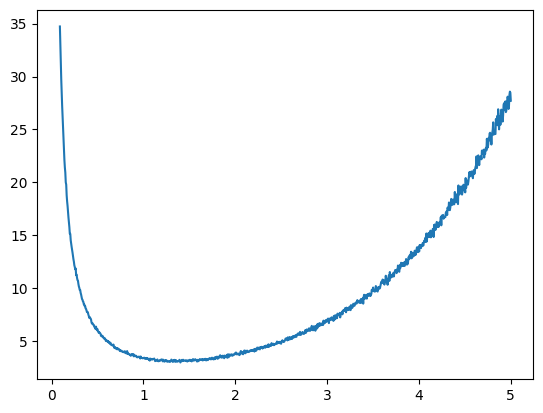

In [20]:
import matplotlib.pyplot as plt
lambda_opt = 1.354828644

def var_anal(lam):
    return (-1 + np.exp(2 + lam))/(lam*(2 + lam)) - (np.exp(1) - 1)^2

def variance(lam, n):
    Us1 = rnd.uniform(size = n)
    Us2 = rnd.uniform(size = n)
    return 1/lam * np.mean(np.exp((2+lam)*Us1)) - np.mean(np.exp(Us2))**2

lams = np.linspace(0.09, 5, 1000)
ys = np.zeros(1000)
for i in range(len(lams)):
    ys[i] = variance(lams[i], 10000)
print("Theoretical variance at optimal lambda is", np.min(ys))



plt.plot(lams, ys)

def g(x,lam):
    return lam * np.exp(-lam * x)

def f(x):
    b1 = x > 0
    b2 = x < 1
    return b1 * b2
def h(x):
    return np.exp(x)

n = 10000
lam = lambda_opt



n = 10000
Xs_crude = crudeMC(n)
mean = np.mean(Xs_crude)
var = np.var(Xs_crude)
s = np.sqrt(var / len(Xs_crude))
a = stats.norm.ppf(alpha/2)
b = stats.norm.ppf(1 - alpha/2)
print("Using Crude Monte Carlo")
print(f"Mean is {round(mean,4)}, with confidence interval [{round(mean + s * a,3)},{round(mean + s * b,3)}]")
print(f"Width of CI = {round(abs(mean + s * a - mean - s*b),3)}")

We note here that the variance of our sample, when using the optimal lambda, is close to the variance we'ed expect given the plot. Using importance sampling with this $g(x)$ we would not expected to find a lower variance.

We can try the same thing, now with $\lambda  = 3.5$ , where we would expect to see a sample variance aroung $10$, which we indeed do.

In [17]:
n = 10000
lam = 3.5
ys = rnd.exponential(scale = 1/lam, size = n)

zs = f(ys) * h(ys) / g(ys, lam)

mean = np.mean(zs)
var = np.var(zs)

print(f"Using lambda = {lam} we instead find a variance of", var)

Using lambda = 3.5 we instead find a variance of 9.901624437913682


### 9) Deriving the IS estimator for the mean of a Pareto distribution

pdf for a arbritray Pareto distribution is $f(x) = \frac{k}{y} \left(\frac{\beta}{y}\right)^k$. From the lectures we know that the first moment distribution of a Pareto distribution is just a Pareto distribution with paramters $\beta$ and $k-1$. Thus

$$g(y) = \frac{k-1}{y} \left(\frac{\beta}{y}\right)^{k-1}.$$

As we're estimating the mean, set $h(y) =y.$ Now the IS estimator for the mean is

$$\frac{f(y)h(y)}{g(y)} = \frac{\frac{k}{y} \left(\frac{\beta}{y}\right)^k\cdot y}{\frac{k-1}{y} \left(\frac{\beta}{y}\right)^{k-1}} = \frac{yk}{k-1}\frac{\left(\frac{\beta}{y}\right)^k}{\left(\frac{\beta}{y}\right)^{k-1}} = \frac{yk}{k-1} \frac{\beta}{y} = \beta \frac{k}{k-1}. $$
Which we know is just the mean of the original Pareto distribution $f(x)$, i.e. we should be sampling exactly the mean! Which we do, with an exact CI.

In [18]:
k = 2
def g(x):
    return (k-1) /(x) * (1/x)**(k-1)

def f(x):
    return k /(x) * (1/x)**k
def h(x):
    return x

n = 100
lam = lambda_opt
ys = rnd.exponential(scale = 1/lam, size = n)
beta = 1
zs = f(ys) * h(ys) / g(ys)
alpha = 0.05
mean = np.mean(zs)
var = np.var(zs)
s = np.sqrt(var / len(zs))
a = stats.norm.ppf(alpha/2)
b = stats.norm.ppf(1 - alpha/2)
print("Using importance sampling to sample the mean of a pareto distribution using its first moment") 
print(f"Mean is {round(mean,4)}, with confidence interval [{round(mean + s * a,3)},{round(mean + s * b,3)}]")
print(f"Width of CI = {round(abs(mean + s * a - mean - s*b),3)}")

print(f"Exact solution for the Pareto distribution mean {k/(k-1) * beta}")

Using importance sampling to sample the mean of a pareto distribution using its first moment
Mean is 2.0, with confidence interval [2.0,2.0]
Width of CI = 0.0
Exact solution for the Pareto distribution mean 2.0


In this case sampling values from a constant value works out, because we know the mean of the Pareto distribution. This approach could be used, but it would be nesecary to know for certain that you´re sampling from the right constant. It could be possible to choose a $g(x)$ such that $\frac{h(x)f(x)}{g(x)}$ is a constant, which is not the mean of $f(x)$, in this case you would end ud with $100$% confidence, in something which is not correct. Gauranteing that you sample from the constant mean, would require you knowing the mean, but then there would be no reason for this approach.

For the previous case $f(x) = \lambda e^{-\lambda x}$ use $g(x) = x e ^{-\lambda x}$. To sample from only the mean get

$$\frac{x\cdot \lambda e^{-\lambda x}}{x e ^{-\lambda x}} = \lambda.$$

In [5]:
beta = 0.005
k = 2
def g(x, beta, k):
    return 1/ (np.exp(1) - 1)
def f(x):
    return (x > 0) * (x < 1)
def h(x):
    return np.exp(x)

def pareto(beta, k, n = 10000): 
    Us = np.random.uniform(size = n)
    Xs = beta * (Us**(-1/k)-1)
    return Xs

ys = pareto(beta, k)
print(ys[0:5])


zs = f(ys) * h(ys) / g(ys, beta, k)
print(g(ys, beta, k))

mean = np.mean(zs)
var = np.var(zs)
alpha = 0.05
print("Actual variance of sample at optimal lambda is", var)
s = np.sqrt(var / len(zs))
a = stats.norm.ppf(alpha/2)
b = stats.norm.ppf(1 - alpha/2)
print("Using importance sampling")
print(f"Mean is {round(mean,4)}, with confidence interval [{round(mean + s * a,3)},{round(mean + s * b,3)}]")
print(f"Width of CI = {round(abs(mean + s * a - mean - s*b),3)}")

[7.69084652e-04 5.82547562e-05 2.38576115e-04 2.36643190e-03
 3.80846481e-04]
0.5819767068693265
Actual variance of sample at optimal lambda is 0.0007374226510054708
Using importance sampling
Mean is 1.7271, with confidence interval [1.727,1.728]
Width of CI = 0.001
